In [1]:
import pandas as pd
import seaborn as sns
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,mean_squared_error
import joblib

In [2]:
df = pd.read_csv('../data/cubic_zirconia.csv', index_col = 0)
df.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
1,0.30,Ideal,E,SI1,62.1,58.0,4.27,4.29,2.66,499
2,0.33,Premium,G,IF,60.8,58.0,4.42,4.46,2.70,984
3,0.90,Very Good,E,VVS2,62.2,60.0,6.04,6.12,3.78,6289
4,0.42,Ideal,F,VS1,61.6,56.0,4.82,4.80,2.96,1082
5,0.31,Ideal,F,VVS1,60.4,59.0,4.35,4.43,2.65,779


In [3]:
df.shape

(26967, 10)

In [4]:
df.isna().sum()

carat        0
cut          0
color        0
clarity      0
depth      697
table        0
x            0
y            0
z            0
price        0
dtype: int64

In [5]:
df = df.loc[~df.depth.isnull()]
df.shape

(26270, 10)

In [6]:
df.describe()

,carat,depth,table,x,y,z,price
count,26270.000000,26270.000000,26270.000000,26270.000000,26270.000000,26270.000000,26270.000000
mean,0.797995,61.745147,57.456011,5.729167,5.732967,3.536636,3937.973734
std,0.477214,1.412860,2.230776,1.127515,1.166330,0.699335,4022.189341
min,0.200000,50.800000,49.000000,0.000000,0.000000,0.000000,326.000000
25%,0.400000,61.000000,56.000000,4.710000,4.720000,2.900000,945.000000
50%,0.700000,61.800000,57.000000,5.690000,5.700000,3.520000,2375.000000
75%,1.050000,62.500000,59.000000,6.550000,6.540000,4.040000,5361.000000
max,4.500000,73.600000,79.000000,10.230000,58.900000,8.060000,18818.000000


<Axes: xlabel='carat'>

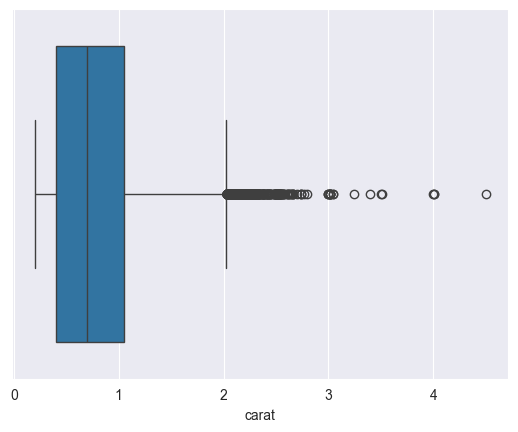

In [7]:
sns.boxplot(df, x='carat')

<Axes: xlabel='depth'>

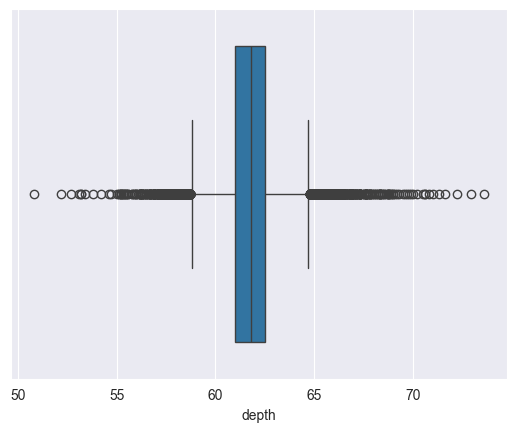

In [8]:
sns.boxplot(df, x='depth')

<Axes: xlabel='table'>

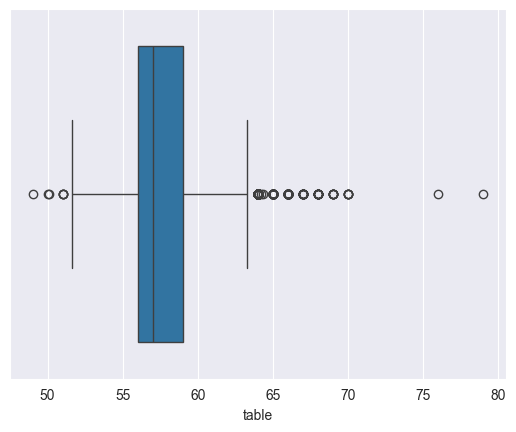

In [9]:
sns.boxplot(df, x='table')

In [10]:
def outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return df.loc[~((df[col] < lower_bound) | (df[col] > upper_bound))]

[outliers(df, 'carat').shape, outliers(df, 'depth').shape, outliers(df, 'table').shape]

[(25627, 10), (25045, 10), (25961, 10)]

In [11]:
df = outliers(df, 'carat')
df = outliers(df, 'depth')
df = outliers(df, 'table')
df.shape

(24260, 10)

In [12]:
df.loc[(df.x == 0) | (df.y == 0) | (df.z == 0),].shape

(5, 10)

It should be impossible for a gem to not have any of these dimensions

In [13]:
df = df.loc[~(df.x == 0) & ~(df.y == 0) & ~(df.z == 0),]
df.shape

(24255, 10)

<Axes: >

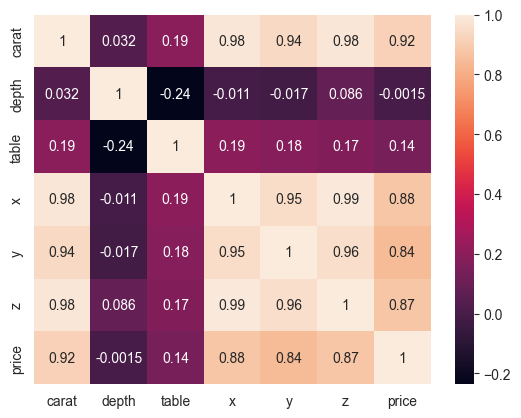

In [14]:
sns.heatmap(df[['carat', 'depth', 'table', 'x', 'y', 'z', 'price']].corr(), annot=True)

x, y & z have high correlation between each other and with carat. It is better to drop them because they are redundant

In [15]:
df = df.drop(columns=['x', 'y', 'z',  ])
df.head()

,carat,cut,color,clarity,depth,table,price
1,0.30,Ideal,E,SI1,62.1,58.0,499
2,0.33,Premium,G,IF,60.8,58.0,984
3,0.90,Very Good,E,VVS2,62.2,60.0,6289
4,0.42,Ideal,F,VS1,61.6,56.0,1082
5,0.31,Ideal,F,VVS1,60.4,59.0,779


In [16]:
df_encoded = pd.get_dummies(df, columns=['cut','color', 'clarity' ])

We drop the price column and save it in a variable as this is the column we want to predict

In [17]:
y = df.price
df = df.drop(columns=['price', 'cut','color', 'clarity'])
df_encoded = df_encoded.drop(columns=['price'])

We also have 2 different testing data, 1 with the categories and one without it to see how the results differ from each other

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.2, random_state = 64)

# Without categorical data

In [19]:
scaler = StandardScaler()

In [20]:
X_norm = scaler.fit_transform(X_train)

In [21]:
X_norm_test = scaler.transform(X_test)

In [22]:
joblib.dump(scaler, '../models/scaler_no_cat.z')

['../models/scaler_no_cat.z']

## SVR

In [23]:
svr = SVR()

In [24]:
svr.fit(X_norm, y_train)

SVR()

In [25]:
y_pred = svr.predict(X_norm_test)

In [26]:
svr_without_categories = [mean_squared_error(y_test,y_pred), r2_score(y_test,y_pred)]
svr_without_categories[0] #mse

8349757.20330708

In [27]:
svr_without_categories[1] #r2 sore

0.38019324120316267

In [28]:
joblib.dump(svr, '../models/svr_no_cat.z')

['../models/svr_no_cat.z']

## Linear regression

In [29]:
lr = LinearRegression()

In [30]:
lr.fit(X_norm, y_train)

LinearRegression()

In [31]:
y_pred = lr.predict(X_norm_test)

In [32]:
lr_without_categories = [mean_squared_error(y_test,y_pred), r2_score(y_test,y_pred)]
lr_without_categories[0] #mse

2188847.364092228

In [33]:
lr_without_categories[1] #r2 sore

0.8375207377644858

In [34]:
joblib.dump(lr, '../models/lr_no_cat.z')

['../models/lr_no_cat.z']

## Random Forest

In [35]:
rf = RandomForestRegressor(random_state = 0)

In [36]:
rf.fit(X_norm, y_train)

RandomForestRegressor(random_state=0)

In [37]:
y_pred = rf.predict(X_norm_test)

In [38]:
rf_without_categories = [mean_squared_error(y_test,y_pred), r2_score(y_test,y_pred)]
rf_without_categories[0] #mse

2150516.3139689653

In [39]:
rf_without_categories[1] #r2 sore

0.840366071270563

In [40]:
joblib.dump(rf, '../models/rf_no_cat.z')

['../models/rf_no_cat.z']

# With categorical data

In [41]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded, y, test_size = 0.2, random_state = 64)

In [42]:
X_norm = scaler.fit_transform(X_train)

In [43]:
X_norm_test = scaler.transform(X_test)

In [44]:
joblib.dump(scaler, '../models/scaler_with_cat.z')

['../models/scaler_with_cat.z']

## SVR

In [45]:
svr.fit(X_norm, y_train)

SVR()

In [46]:
y_pred = svr.predict(X_norm_test)

In [47]:
svr_with_categories = [mean_squared_error(y_test,y_pred), r2_score(y_test,y_pred)]
svr_with_categories[0] #mse

13795406.223747479

In [48]:
svr_with_categories[1] #r2 sore

-0.024040078008503052

In [49]:
joblib.dump(svr, '../models/svr_with_cat.z')

['../models/svr_with_cat.z']

## Linear Regression

In [50]:
lr.fit(X_norm, y_train)

LinearRegression()

In [51]:
y_pred = lr.predict(X_norm_test)

In [52]:
lr_with_categories = [mean_squared_error(y_test,y_pred), r2_score(y_test,y_pred)]
lr_with_categories[0] #mse

1245988.0063314834

In [53]:
lr_with_categories[1] #r2 sore

0.9075096713712614

In [54]:
joblib.dump(lr, '../models/lr_with_cat.z')

['../models/lr_with_cat.z']

## Random Forest

In [55]:
rf.fit(X_norm, y_train)

RandomForestRegressor(random_state=0)

In [56]:
y_pred = rf.predict(X_norm_test)

In [57]:
rf_with_categories = [mean_squared_error(y_test,y_pred), r2_score(y_test,y_pred)]
rf_with_categories[0] #mse

254659.98323546807

In [58]:
rf_with_categories[1] #r2 sore

0.981096458859676

In [59]:
joblib.dump(rf, '../models/rf_with_cat.z')

['../models/rf_with_cat.z']

# Comparison

Our main objective is to lower the mean squared error and to increase the R2 score, we'll now compare the results of the different models training with and without the categories.

## MSE

In [60]:
[svr_with_categories[0] - svr_without_categories[0],  lr_with_categories[0] - lr_without_categories[0], rf_with_categories[0] - rf_without_categories[0]]

[5445649.020440399, -942859.3577607446, -1895856.3307334972]

Only with SVR the MSE was worse when the categorical data was included (with one-hot encoding). The other 2 models (linear regression and random forest) performed better when the extra (categorical) data was included.

## R2 Score

In [61]:
[svr_with_categories[1] - svr_without_categories[1],  lr_with_categories[1] - lr_without_categories[1], rf_with_categories[1] - rf_without_categories[1]]

[-0.4042333192116657, 0.0699889336067756, 0.14073038758911305]

Similar to the MSE results, SVR performed worse when the training data included the encoded categorical data. We can see that the increase is significant in linear regression (an increase of 6.5%) and even more in Random Forest (an increase of 11.9%).

# Conclusions

- The random forest model outperformed both the linear regressor and the SVR with and without the encoded categorical data.
- Overall we can say that the inclusion of categorical data with one-hot encoding generated better predictions for the models, specially for Random Forests, however this was not the case with SVR.
- SVR had really bad results, this may be attributed to overlap in data or to outliers in the data, data cleaning should help increasing the performance of this model the most.
- We can see that Random Forest is a really robust model that can give good results without the need of a lot of data cleaning.
- Data cleaning did increase the performance of SVR and Random Forest by a little, and decreased the performance by a little too, the change n the performance was about a 0.7% each. Not a lot but with it we manage to obtain the best regression model that was the Random Forest with categorical data.

# Insights

- I learned that if I normalized the data in training & testing I needed to normalize the input data in production. It is kinda obvious if you think about it, but it just didn't pass my mind until I was working with it.

- I learned to use joblib to save & load my trained models. Most of the time I don't save the models, only let then in the notebook, so I didn't know how to save the models, I have only used `keras.callbacks.ModelCheckpoint` to save NN, nothing more. It was good to learn this.

- I used a dictionary to access the correct category in a O(1) time complexity instead of iterating through the list of arguments for each value, it feels like the fastest way of initializing the arguments for the models when one-hot encoding is being used. I need to see if there are better alternatives.

# Testing Stuff

Seeing how the models work with joblib

In [62]:
reg = joblib.load("../models/rf_no_cat.z")

In [63]:
X_test

,carat,depth,table,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_D,color_E,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
16015,0.93,60.8,59.0,False,False,False,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False
20698,1.19,63.5,57.0,False,False,False,False,True,True,False,...,False,False,False,False,False,True,False,False,False,False
3107,0.50,61.8,57.0,False,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
1634,1.53,61.5,56.0,False,False,True,False,False,False,False,...,True,False,False,False,False,False,False,True,False,False
24074,0.50,60.8,54.0,False,False,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26321,2.01,61.7,56.0,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
16723,1.01,62.8,59.0,False,False,False,True,False,False,False,...,False,False,False,False,True,False,False,False,False,False
19325,0.64,60.1,60.0,False,False,False,True,False,False,False,...,False,False,False,False,True,False,False,False,False,False
22818,0.41,62.0,56.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False


In [64]:
df.head()

,carat,depth,table
1,0.30,62.1,58.0
2,0.33,60.8,58.0
3,0.90,62.2,60.0
4,0.42,61.6,56.0
5,0.31,60.4,59.0


In [65]:
df = pd.read_csv('../data/cubic_zirconia.csv', index_col = 0)
df.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
1,0.30,Ideal,E,SI1,62.1,58.0,4.27,4.29,2.66,499
2,0.33,Premium,G,IF,60.8,58.0,4.42,4.46,2.70,984
3,0.90,Very Good,E,VVS2,62.2,60.0,6.04,6.12,3.78,6289
4,0.42,Ideal,F,VS1,61.6,56.0,4.82,4.80,2.96,1082
5,0.31,Ideal,F,VVS1,60.4,59.0,4.35,4.43,2.65,779


In [66]:
X_test.columns

Index(['carat', 'depth', 'table', 'cut_Fair', 'cut_Good', 'cut_Ideal',
       'cut_Premium', 'cut_Very Good', 'color_D', 'color_E', 'color_F',
       'color_G', 'color_H', 'color_I', 'color_J', 'clarity_I1', 'clarity_IF',
       'clarity_SI1', 'clarity_SI2', 'clarity_VS1', 'clarity_VS2',
       'clarity_VVS1', 'clarity_VVS2'],
      dtype='object')

In [67]:
X_test.columns[3:8]

Index(['cut_Fair', 'cut_Good', 'cut_Ideal', 'cut_Premium', 'cut_Very Good'], dtype='object')

In [68]:
X_test.columns[8:15]


Index(['color_D', 'color_E', 'color_F', 'color_G', 'color_H', 'color_I',
       'color_J'],
      dtype='object')

In [69]:
X_test.columns[15:23]

Index(['clarity_I1', 'clarity_IF', 'clarity_SI1', 'clarity_SI2', 'clarity_VS1',
       'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2'],
      dtype='object')

In [70]:
[0 for i in range(23)]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [71]:
reg = joblib.load("../models/rf_no_cat.z")
scaler = joblib.load("../models/scaler_no_cat.z")
input_norm = scaler.transform(
    pd.DataFrame([[0.3, 62.1, 58]], columns=['carat', 'depth', 'table'])
)
reg.predict(input_norm)

array([658.65682777])